<a href="https://colab.research.google.com/github/sgsoul/applied-ai/blob/main/applied_ai_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация цветов с помощью свёрточных нейронных сетей. 


В работе необходимо познакомится с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU. После с ознакомления, выполнить практическое задане в конце данной тетради (notebook).

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4242 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/My Drive/data/flowers".

Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения. В меню сверху: Среда выполнения -> Сменить среду выполнения

Первым делом разберите более детально код выполнив код ниже.

# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [1]:
import numpy as np   
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


Блок для соединения с Google Colab 

In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'itmo/flowers'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
#%cp -r $FOLDERNAME ../../
#%cd ../../
%cd data/flowers/
#!bash get_datasets.sh
#%cd ../../

#+For kaggle______________________________________________
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# FOLDERNAME = '/kaggle/input/flowers-recognition/flowers'
# %cd /kaggle/input/flowers-recognition/flowers

Mounted at /content/drive
/content/drive/My Drive
[Errno 2] No such file or directory: 'data/flowers/'
/content/drive/My Drive


In [4]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок: 
dataset = ImageFolder('/content/drive/My Drive/itmo/flowers', transform=prepare_imgs)

In [5]:
dataset.imgs[2]

('/content/drive/My Drive/itmo/flowers/daisy/10172379554_b296050f82_n.jpg', 0)

In [6]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы 
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои

In [7]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=200704, out_features=1024, bias=True)
  (17): ReLU()
  (18): Linear(in_features=1024, out_features=512, bias=True)
  (19): ReLU()
  (20): Lin

Задаем гиперпараметры для обучения:

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [8]:
batch_size = 32 
optimizer = torch.optim.Adam(params = model.parameters()) 
lr = 0.001 

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [9]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Размер обучающего и валидационного датасета:  3317 1000


Функция для подсчета Accuracy

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [11]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device) 
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track             

# Обучаем базовую модель

Проверим загрузку видеокарты, прежде чем запустить обучение:

Запускаем обучение на 10 эпох

In [12]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

100%|██████████| 104/104 [15:01<00:00,  8.67s/it]


[training] Epoch: 0.00. Loss: 1.49. Accuracy: 31.38% 


100%|██████████| 32/32 [04:25<00:00,  8.31s/it]


[validation] Epoch: 0.00. Loss: 1.30. Accuracy: 40.80% 


100%|██████████| 104/104 [00:36<00:00,  2.88it/s]


[training] Epoch: 1.00. Loss: 1.35. Accuracy: 39.39% 


100%|██████████| 32/32 [00:05<00:00,  5.82it/s]


[validation] Epoch: 1.00. Loss: 1.21. Accuracy: 46.90% 


100%|██████████| 104/104 [00:35<00:00,  2.96it/s]


[training] Epoch: 2.00. Loss: 1.24. Accuracy: 44.74% 


100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


[validation] Epoch: 2.00. Loss: 1.15. Accuracy: 49.50% 


100%|██████████| 104/104 [00:35<00:00,  2.92it/s]


[training] Epoch: 3.00. Loss: 1.16. Accuracy: 48.94% 


100%|██████████| 32/32 [00:05<00:00,  5.88it/s]


[validation] Epoch: 3.00. Loss: 1.11. Accuracy: 52.17% 


100%|██████████| 104/104 [00:35<00:00,  2.95it/s]


[training] Epoch: 4.00. Loss: 1.08. Accuracy: 53.07% 


100%|██████████| 32/32 [00:05<00:00,  5.78it/s]


[validation] Epoch: 4.00. Loss: 1.09. Accuracy: 54.28% 


100%|██████████| 104/104 [00:35<00:00,  2.94it/s]


[training] Epoch: 5.00. Loss: 0.99. Accuracy: 57.56% 


100%|██████████| 32/32 [00:05<00:00,  5.68it/s]


[validation] Epoch: 5.00. Loss: 1.13. Accuracy: 55.48% 


100%|██████████| 104/104 [00:35<00:00,  2.93it/s]


[training] Epoch: 6.00. Loss: 0.89. Accuracy: 62.24% 


100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


[validation] Epoch: 6.00. Loss: 1.18. Accuracy: 56.56% 


100%|██████████| 104/104 [00:35<00:00,  2.95it/s]


[training] Epoch: 7.00. Loss: 0.81. Accuracy: 66.12% 


100%|██████████| 32/32 [00:05<00:00,  5.86it/s]


[validation] Epoch: 7.00. Loss: 1.22. Accuracy: 57.08% 


100%|██████████| 104/104 [00:35<00:00,  2.94it/s]


[training] Epoch: 8.00. Loss: 0.74. Accuracy: 69.36% 


100%|██████████| 32/32 [00:05<00:00,  5.70it/s]


[validation] Epoch: 8.00. Loss: 1.38. Accuracy: 57.26% 


100%|██████████| 104/104 [00:35<00:00,  2.94it/s]


[training] Epoch: 9.00. Loss: 0.67. Accuracy: 72.18% 


100%|██████████| 32/32 [00:05<00:00,  5.78it/s]

[validation] Epoch: 9.00. Loss: 1.48. Accuracy: 57.85% 


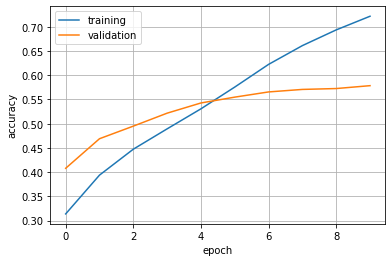

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

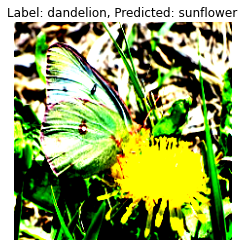

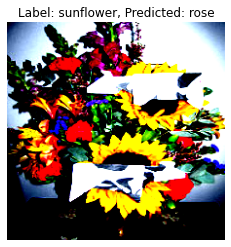

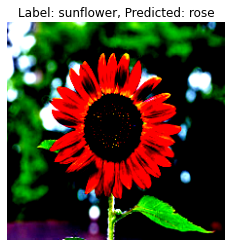

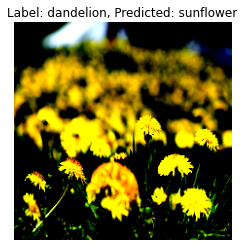

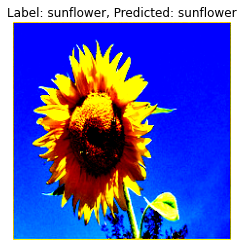

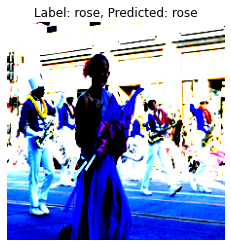

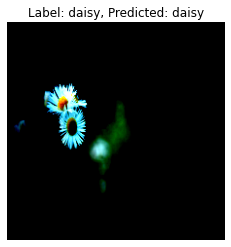

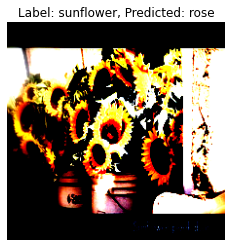

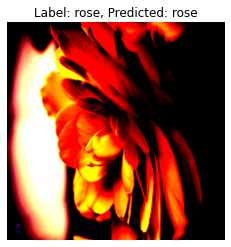

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

# Практическое задание 

В пракическом задание необходимо обучить еще одну сверточную архитектуру для задач классификации цветов. 

В выбранной Вами архитектуре также необходимо разобраться с основными её параметрами и принципами работы.

Посмотрите как использовать [модели в PyTorch](https://pytorch.org/vision/stable/models.html) для классификации, выберите одну и используя transfer learning до-обучите модель на классификацию цветов. Чтобы это сделать замените ____ в ячейках ниже на работающий код.




In [15]:
# Выберите модель из списка доступных в PyTorch моделей
# Не забудьте указать, что она модель должна быть предобучена!
model = torchvision.models.googlenet(pretrained = True)
model

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [16]:
# Функция для заморозки весов модели
def set_parameter_requires_grad(model):  
  for param in model.parameters():
    param.requires_grad = False

set_parameter_requires_grad(model) # передайте модель в функцию для "заморозки" градиента

In [17]:
model.fc =nn.Linear(1024,5) # Меняем последний слой модели Зачем? Сколькой нужно выходов?

In [18]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

fc.weight
fc.bias


In [19]:
model.to(device) # Отправляем модель на GPU
optimizer = torch.optim.Adam(params = model.parameters()) # алгоритм оптимизации
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10) #обратить внимание на loss_track и accuracy_track

100%|██████████| 104/104 [00:16<00:00,  6.34it/s]


[training] Epoch: 0.00. Loss: 0.98. Accuracy: 66.93% 


100%|██████████| 32/32 [00:05<00:00,  6.39it/s]


[validation] Epoch: 0.00. Loss: 0.61. Accuracy: 82.50% 


100%|██████████| 104/104 [00:15<00:00,  6.51it/s]


[training] Epoch: 1.00. Loss: 0.78. Accuracy: 73.98% 


100%|██████████| 32/32 [00:04<00:00,  6.47it/s]


[validation] Epoch: 1.00. Loss: 0.56. Accuracy: 84.00% 


100%|██████████| 104/104 [00:16<00:00,  6.49it/s]


[training] Epoch: 2.00. Loss: 0.69. Accuracy: 77.22% 


100%|██████████| 32/32 [00:04<00:00,  6.45it/s]


[validation] Epoch: 2.00. Loss: 0.52. Accuracy: 84.43% 


100%|██████████| 104/104 [00:16<00:00,  6.34it/s]


[training] Epoch: 3.00. Loss: 0.63. Accuracy: 78.99% 


100%|██████████| 32/32 [00:05<00:00,  6.39it/s]


[validation] Epoch: 3.00. Loss: 0.49. Accuracy: 84.90% 


100%|██████████| 104/104 [00:16<00:00,  6.45it/s]


[training] Epoch: 4.00. Loss: 0.58. Accuracy: 80.31% 


100%|██████████| 32/32 [00:04<00:00,  6.53it/s]


[validation] Epoch: 4.00. Loss: 0.48. Accuracy: 85.32% 


100%|██████████| 104/104 [00:16<00:00,  6.40it/s]


[training] Epoch: 5.00. Loss: 0.56. Accuracy: 81.15% 


100%|██████████| 32/32 [00:05<00:00,  6.38it/s]


[validation] Epoch: 5.00. Loss: 0.46. Accuracy: 85.60% 


100%|██████████| 104/104 [00:16<00:00,  6.41it/s]


[training] Epoch: 6.00. Loss: 0.53. Accuracy: 81.90% 


100%|██████████| 32/32 [00:04<00:00,  6.51it/s]


[validation] Epoch: 6.00. Loss: 0.45. Accuracy: 85.83% 


100%|██████████| 104/104 [00:16<00:00,  6.47it/s]


[training] Epoch: 7.00. Loss: 0.51. Accuracy: 82.63% 


100%|██████████| 32/32 [00:04<00:00,  6.45it/s]


[validation] Epoch: 7.00. Loss: 0.44. Accuracy: 85.94% 


100%|██████████| 104/104 [00:16<00:00,  6.47it/s]


[training] Epoch: 8.00. Loss: 0.49. Accuracy: 83.19% 


100%|██████████| 32/32 [00:04<00:00,  6.45it/s]


[validation] Epoch: 8.00. Loss: 0.43. Accuracy: 86.13% 


100%|██████████| 104/104 [00:16<00:00,  6.38it/s]


[training] Epoch: 9.00. Loss: 0.48. Accuracy: 83.60% 


100%|██████████| 32/32 [00:04<00:00,  6.41it/s]

[validation] Epoch: 9.00. Loss: 0.42. Accuracy: 86.40% 


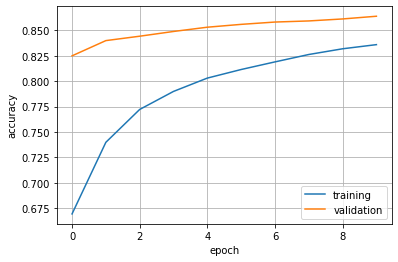

In [20]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

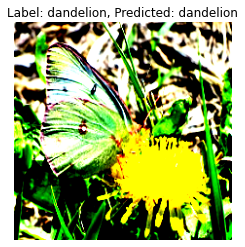

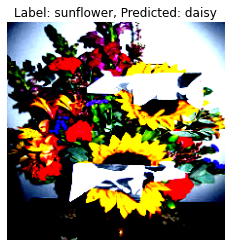

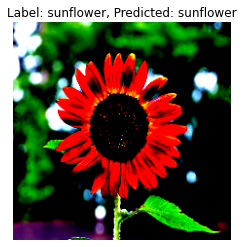

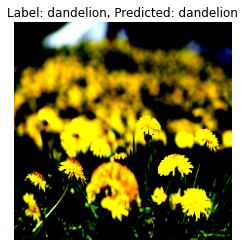

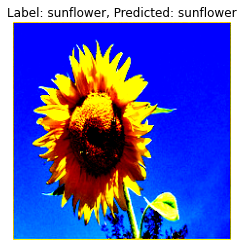

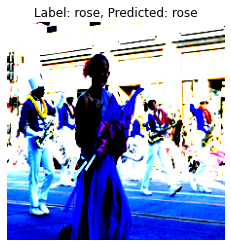

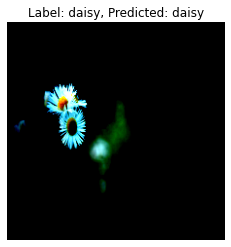

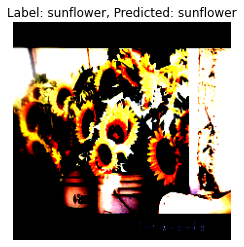

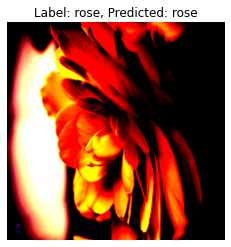

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    xb = img.unsqueeze(0).to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, model)))
  plt.show()

По желанию, можно сохранить веса модели.

In [25]:
weights_fname = '/content/drive/My Drive/itmo/weights.pth'
torch.save(model.state_dict(), weights_fname)

## Вопросы и задания.
Добавте описание архитектуры выбранной Вами предобученой сверточной нейронной сети.

Как работает выбранная вами модель сверточной нейронной сети? Какие параметры?

В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?

Что такое transfer learning? Что такое предобучена нейронная сеть?

Что такое функция для заморозки весов модели? 

Как работает блок "Сверточная нейросеть с нуля"? Описать сверточный и пулинговый слой.